In [1]:
2201
!pip install pyspark==3.4.1
import os
os.getcwd()
os.chdir('D:/SAMARIDDIN/MSBA')
os.getcwd()

'D:\\SAMARIDDIN\\MSBA'

*** Things to do ***
1) deal with NANs
2) work on descriptive stats into Graphs (average departure delay by carrier (using normalzied Delay))
3) convert to Dask instead of Pandas
4) figure out penalty for Normalized data
5) fix Lowest probability of delays or cancellations
***Once completed: ***
6) fix Regression and  Classification models
7) create graphs

In [2]:
import os
os.getcwd()
# os.chdir('D:/SAMARIDDIN/MSBA')
os.getcwd()
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat, col, lit

# Create a Spark session
spark = SparkSession.builder.appName("FlightDataProcessing").getOrCreate()

# Load the data
df = spark.read.csv("2009.csv", header=True)

columns = ['flight_id', 'FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 27']
files = ["2010.csv", "2012.csv", "2013.csv", "2014.csv", "2015.csv", "2016.csv", "2017.csv", "2018.csv"]
# Create a new column 'flight_id' by concatenating 'FL_Date' and 'OP_CARRIER_FL_NUM'
df = df.withColumn("flight_id", concat(col("FL_Date"), lit("_"), col("OP_CARRIER_FL_NUM"), lit("_"), col("OP_CARRIER")))
for file in files:
  df1 = spark.read.csv(file, header=True)
  df2 = df1.withColumn("flight_id", concat(col("FL_Date"), lit("_"), col("OP_CARRIER_FL_NUM"), lit("_"), col("OP_CARRIER")))
  df = df.join(df2,on=columns, how='outer')

# Show the DataFrame with the new 'flight_id' column
df.show()


RuntimeError: Java gateway process exited before sending its port number

In [ ]:
df.count()

55490314

In [ ]:
from pyspark.sql.functions import year

# Extract year from 'FL_DATE' and get unique years
unique_years = df.select(year("FL_DATE").alias("year")).distinct()

# Show the result
unique_years.show()

+----+
|year|
+----+
|2018|
|2015|
|2013|
|2014|
|2012|
|2009|
|2016|
|2010|
|2017|
+----+



In [ ]:
from pyspark.sql.functions import avg

# Calculate average departure delay by carrier
avg_delay_by_carrier = df.groupBy("OP_CARRIER").agg(avg("DEP_DELAY").alias("avg_delay"))

# Show the result
avg_delay_by_carrier.show()


+----------+--------------------+
|OP_CARRIER|           avg_delay|
+----------+--------------------+
|        UA|  11.037963088834806|
|        NK|   11.74905877340944|
|        AA|   9.518573459963791|
|        NW|   5.710441971470624|
|        EV|  11.923824750274122|
|        B6|   12.42143317088745|
|        DL|   7.553627246738765|
|        OO|   7.987209547108931|
|        F9|  11.864829739058877|
|        YV|   7.546857999658307|
|        US|   3.952409660795185|
|        MQ|   8.901389963033653|
|        OH|  11.182820470330556|
|        HA|-1.94887452496183...|
|        XE|   7.405384662794554|
|        G4|  12.922574968839358|
|        YX|  7.3396549135325335|
|        AS|  1.8036089511643159|
|        CO|    8.72418855396611|
|        FL|   6.667221553885233|
+----------+--------------------+
only showing top 20 rows



In [ ]:

# Convert to pandas DataFrame
avg_delay_by_carrier_pd = avg_delay_by_carrier.toPandas()

# Sort by average delay
avg_delay_by_carrier_pd = avg_delay_by_carrier_pd.sort_values("avg_delay")


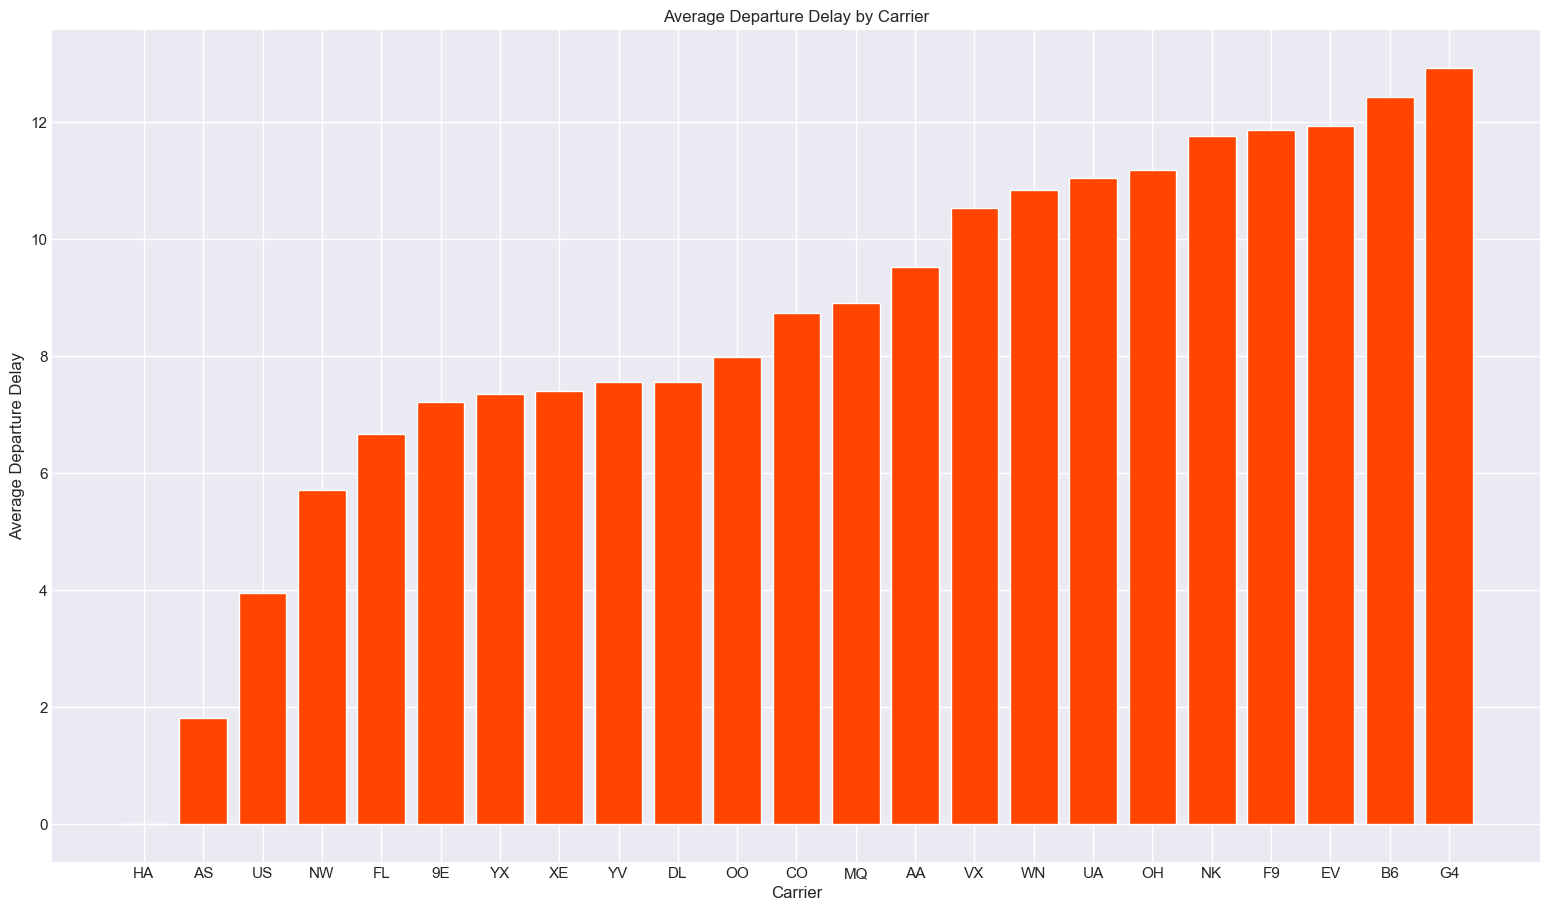

In [ ]:


# Create a bar plot
plt.figure(figsize=(19.2,10.8))
plt.bar(avg_delay_by_carrier_pd["OP_CARRIER"], avg_delay_by_carrier_pd["avg_delay"],color='orangered')
plt.xlabel("Carrier")
plt.ylabel("Average Departure Delay")
plt.title("Average Departure Delay by Carrier")
plt.show()


In [ ]:
# Explaining each type of delay: You can create a summary statistics for each type of delay to understand their distribution
from pyspark.sql.functions import when, col
from pyspark.sql.functions import sum as _sum
delay_types = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
for delay in delay_types:
    df = df.withColumn(delay, when(col(delay).isNull(), 0).otherwise(col(delay)))
delay_types = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
for delay in delay_types:
    df.select(delay).describe().show()



# Define delay types


# Calculate total delays for each type
total_delays = {}
for delay in delay_types:
    result = df.select(delay).groupBy().agg(_sum(delay).alias('total')).collect()
    total_delays[delay] = result[0]['total'] if result else 0

# Convert the total_delays dictionary to a DataFrame
delays_df = pd.DataFrame(list(total_delays.items()), columns=['Delay Type', 'Total Delay'])



+-------+------------------+
|summary|     CARRIER_DELAY|
+-------+------------------+
|  count|          55490314|
|   mean| 3.323506206867022|
| stddev|22.322858609233236|
|    min|                 0|
|    max|             999.0|
+-------+------------------+

+-------+-------------------+
|summary|      WEATHER_DELAY|
+-------+-------------------+
|  count|           55490314|
|   mean|0.49879712340427557|
| stddev|  9.065387219543899|
|    min|                  0|
|    max|              999.0|
+-------+-------------------+

+-------+------------------+
|summary|         NAS_DELAY|
+-------+------------------+
|  count|          55490314|
|   mean| 2.680592724705072|
| stddev|14.080463364826882|
|    min|                 0|
|    max|             998.0|
+-------+------------------+

+-------+--------------------+
|summary|      SECURITY_DELAY|
+-------+--------------------+
|  count|            55490314|
|   mean|0.014562595554964782|
| stddev|   1.044352867108419|
|    min|          

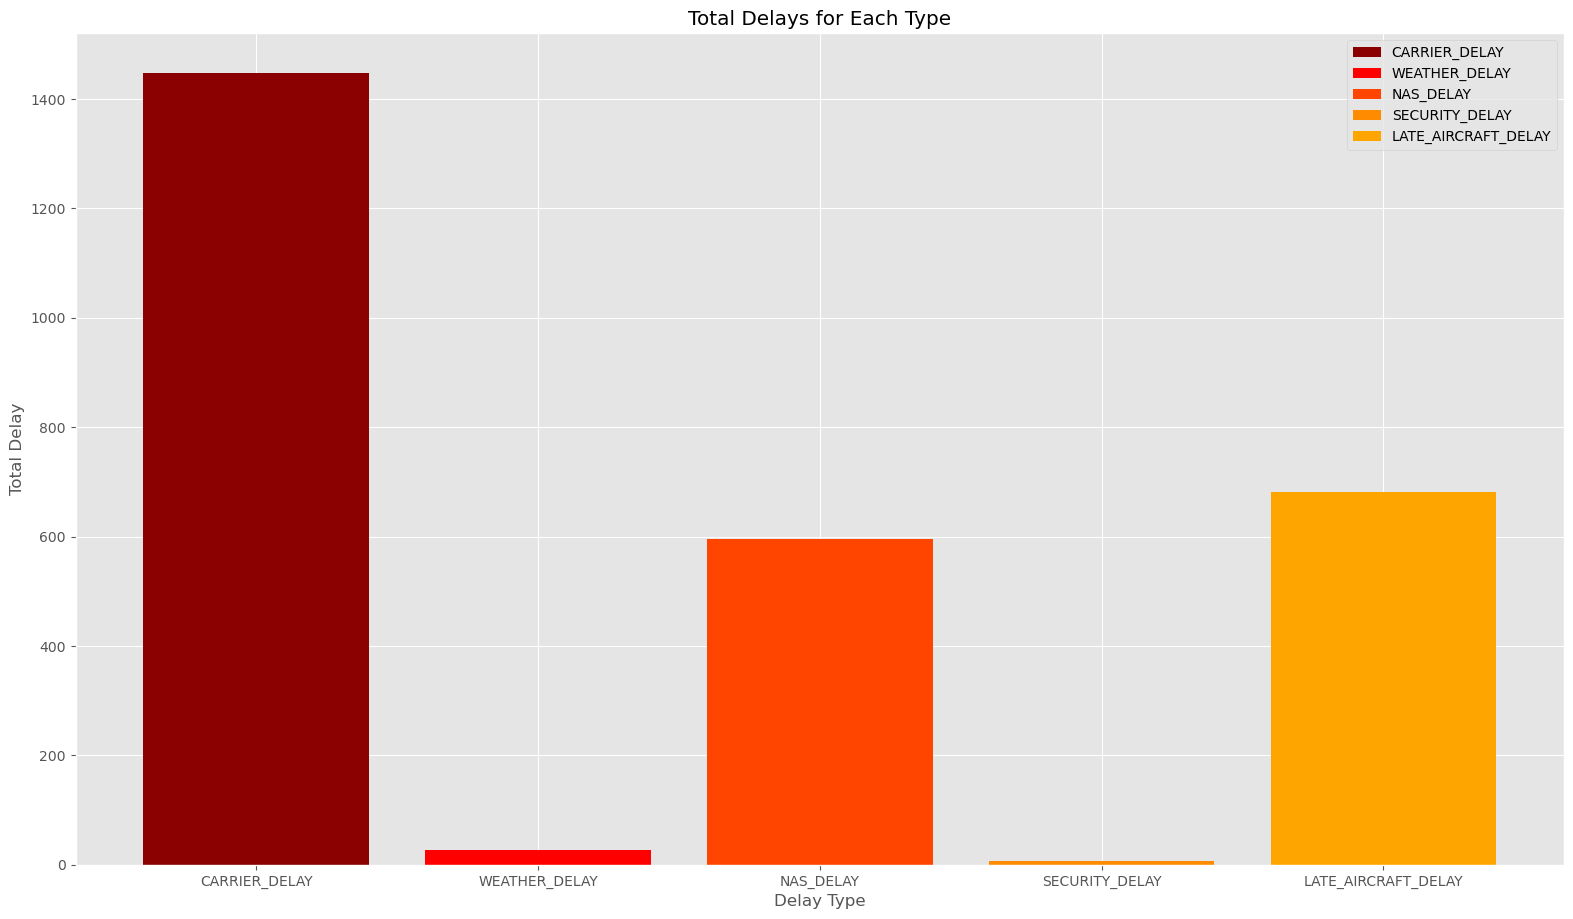

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Use a different theme
plt.style.use('ggplot')

# Define colors
colors = ['darkred', 'red', 'orangered', 'darkorange', 'orange']

# Create bar plot
plt.figure(figsize=(19.2,10.8))
bars = plt.bar(delays_df['Delay Type'], delays_df['Total Delay'], color=colors)
plt.xlabel('Delay Type')
plt.ylabel('Total Delay')
plt.title('Total Delays for Each Type')

# Add legend
plt.legend(bars, delays_df['Delay Type'])

plt.show()


In [ ]:
# Measuring reliability: You can normalize the delay metrics by the number of flights each airline operates.
total_flights_by_carrier = df.groupBy("OP_CARRIER").count()
avg_delay_by_carrier = df.groupBy("OP_CARRIER").agg(avg("DEP_DELAY").alias("avg_delay"))
normalized_delay_by_carrier = avg_delay_by_carrier.join(total_flights_by_carrier, "OP_CARRIER")
normalized_delay_by_carrier = normalized_delay_by_carrier.withColumn("normalized_delay", col("avg_delay") / col("count"))
normalized_delay_by_carrier.show()


# Convert Spark DataFrame to Pandas DataFrame for visualization
normalized_delay_pd = normalized_delay_by_carrier.toPandas()


+----------+-------------------+-----+--------------------+
|OP_CARRIER|          avg_delay|count|    normalized_delay|
+----------+-------------------+-----+--------------------+
|        MQ|  6.587719298245614|  115| 0.05728451563691838|
|        OH| 7.9772727272727275|  134| 0.05953188602442334|
|        XE|-0.3855421686746988|  249|-0.00154836212319...|
+----------+-------------------+-----+--------------------+



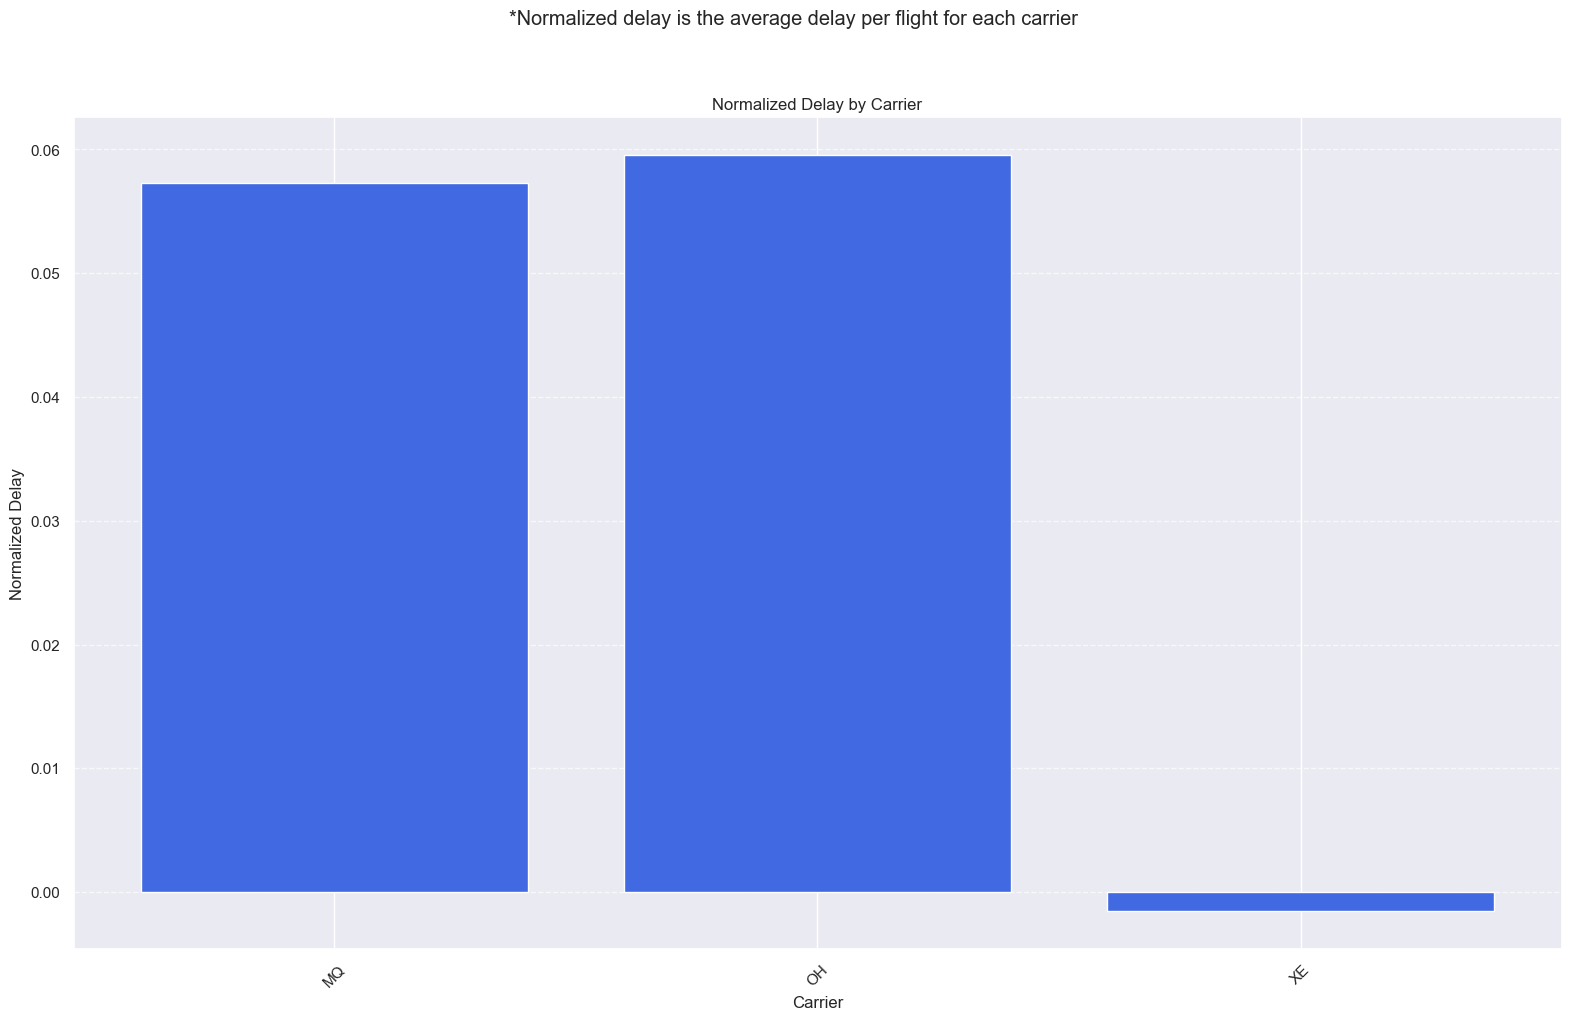

In [ ]:
# Importing required libraries
import matplotlib.pyplot as plt


# Setting the theme
sns.set_theme(style="darkgrid")

# Plotting
plt.figure(figsize=(19.2,10.8))
plt.bar(normalized_delay_pd['OP_CARRIER'], normalized_delay_pd['normalized_delay'], color='royalblue')
plt.suptitle('*Normalized delay is the average delay per flight for each carrier')
plt.title('Normalized Delay by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Normalized Delay')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
normalized_delay_pd = normalized_delay_by_carrier.toPandas()


C:\Users\jadencoin\AppData\Local\Temp\ipykernel_12276\4012408394.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


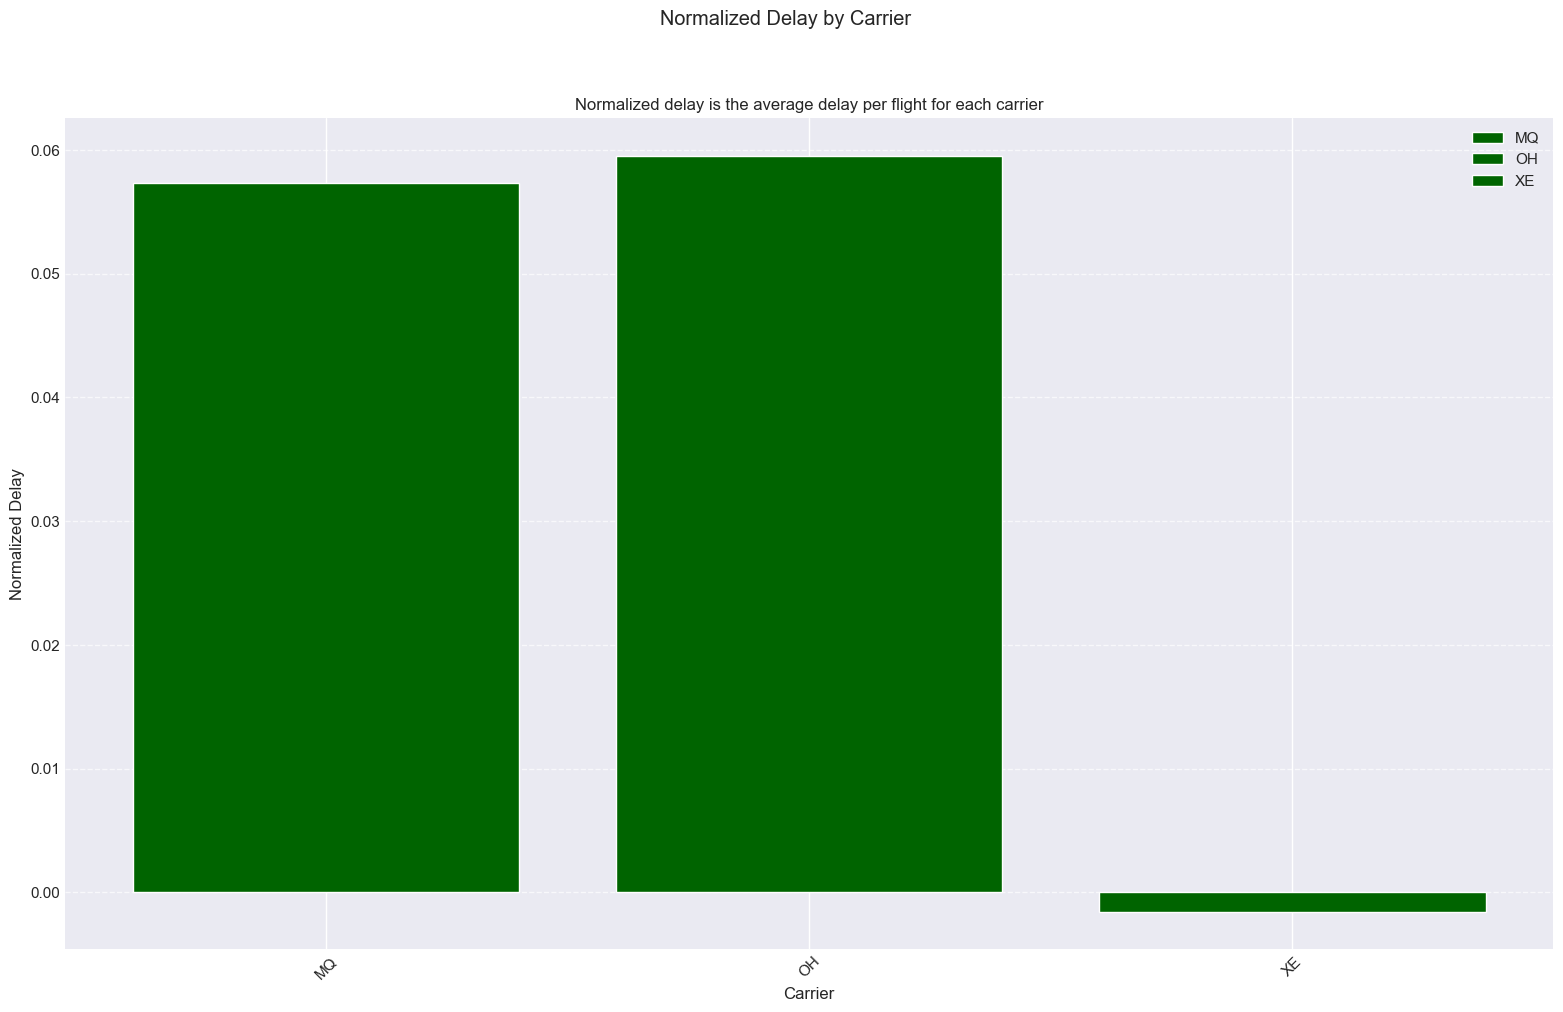

In [ ]:

# Use a different theme
plt.style.use('seaborn-darkgrid')

# Define colors
colors = ['lightgreen', 'limegreen', 'darkgreen']

# Plotting
plt.figure(figsize=(19.2,10.8))
bars = plt.bar(normalized_delay_pd['OP_CARRIER'], normalized_delay_pd['normalized_delay'], color='darkgreen')
plt.suptitle('Normalized Delay by Carrier')
plt.title('Normalized delay is the average delay per flight for each carrier')
plt.xlabel('Carrier')
plt.ylabel('Normalized Delay')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
plt.legend(bars, normalized_delay_pd['OP_CARRIER'])

plt.show()



In [ ]:
# Problematic routes: You can find the routes with the highest average delay.
problematic_routes = df.groupBy("ORIGIN", "DEST").agg(avg("DEP_DELAY").alias("avg_delay"))
problematic_routes.sort("avg_delay", ascending=False).show()

# Convert to Pandas DataFrame for easier plotting
normalized_delay_df = normalized_delay_by_carrier.toPandas()

# Calculate average delay for each route
problematic_routes_df = problematic_routes.toPandas()

+------+----+---------+
|ORIGIN|DEST|avg_delay|
+------+----+---------+
|   MAF| IAH|    173.0|
|   EWR| MEM|    110.0|
|   SDF| MEM|     85.0|
|   SDF| DTW|     70.0|
|   CLE| RIC|     68.0|
|   MKE| JFK|     61.0|
|   DTW| SDF|     55.0|
|   ORF| DTW|     50.0|
|   BOS| CVG|     48.5|
|   DTW| CVG|     45.0|
|   RDU| JFK|     44.0|
|   MEM| IAH|     42.5|
|   CLT| JFK|     40.0|
|   BOS| CMH|     38.0|
|   BGR| DTW|     35.0|
|   MSP| CVG|     30.0|
|   IAH| AEX|     30.0|
|   JFK| IND|     30.0|
|   MSP| EWR|     27.0|
|   CVG| RDU|     25.0|
+------+----+---------+
only showing top 20 rows



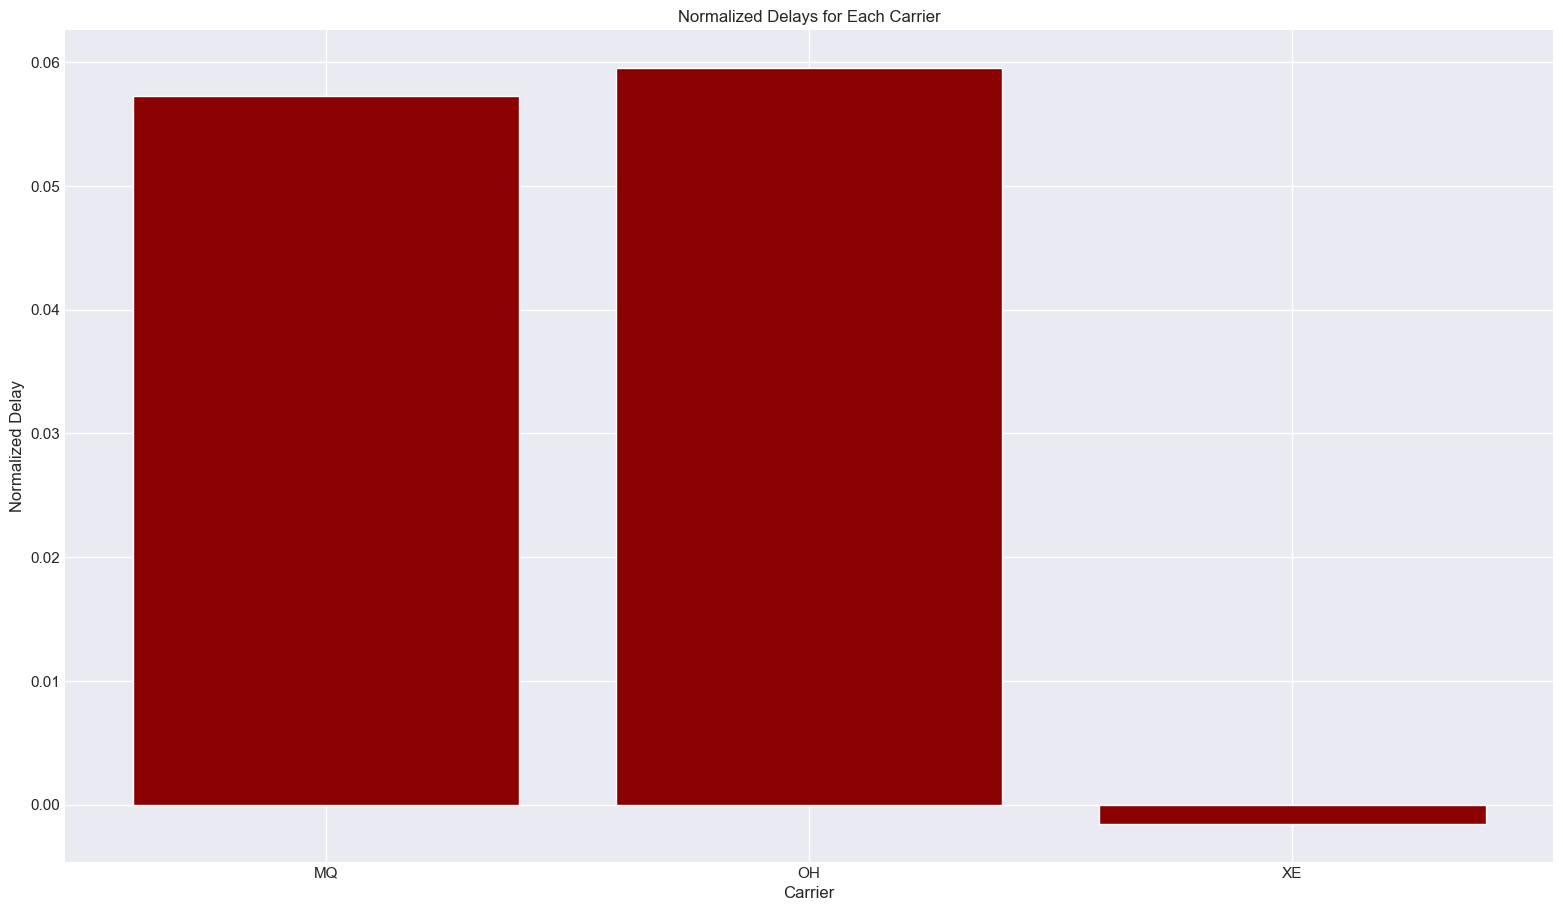

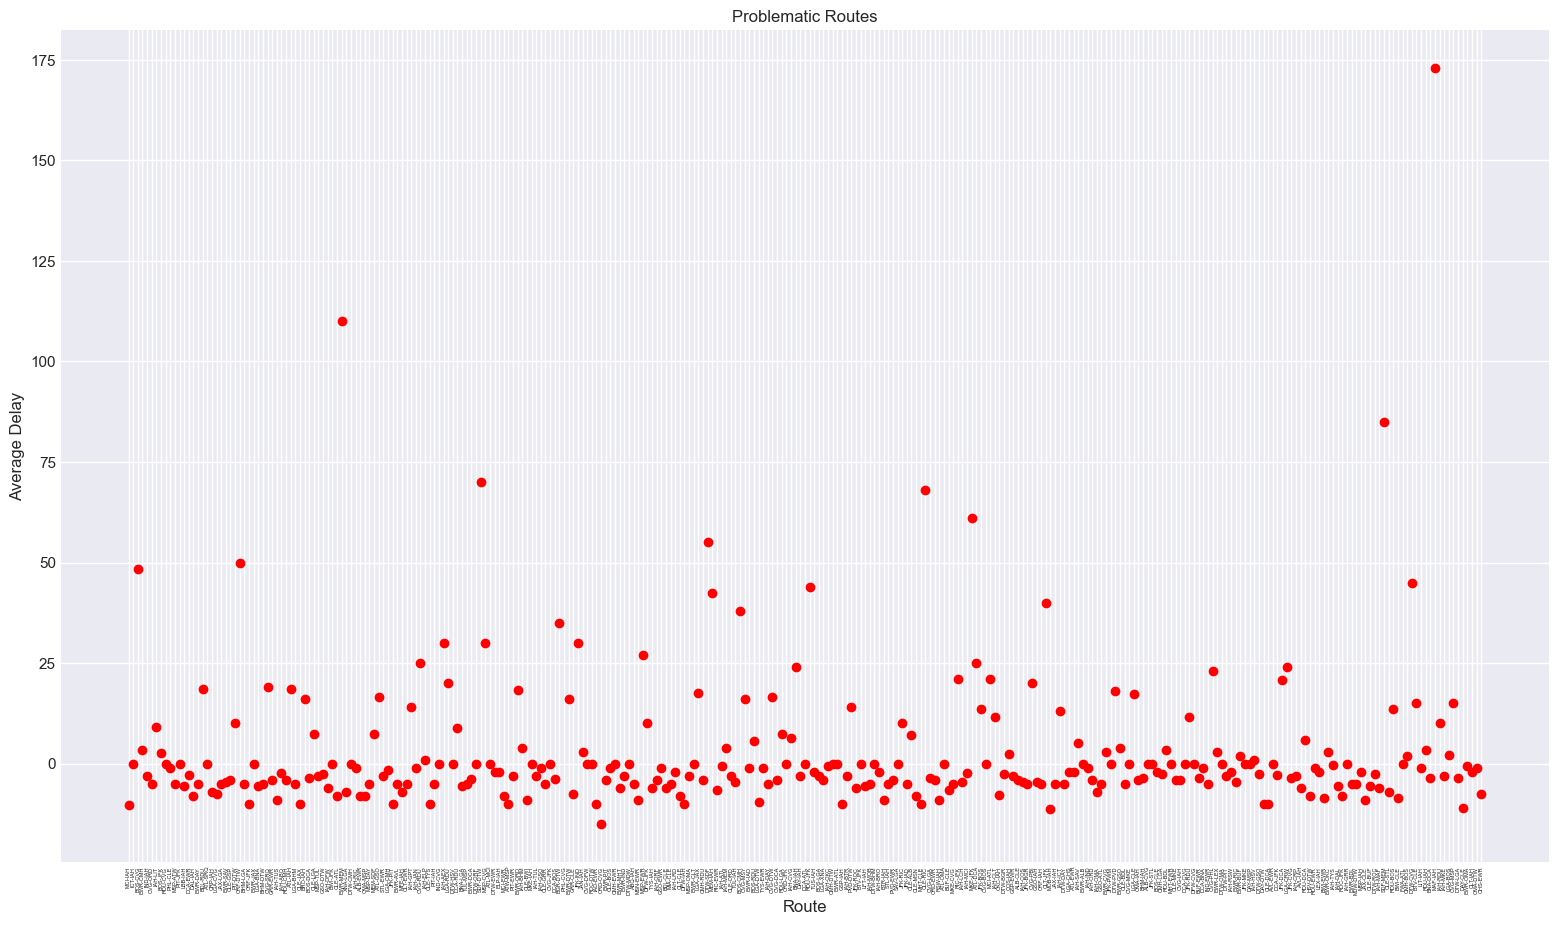

In [ ]:

# Create bar plot for normalized delays
plt.figure(figsize=(19.2,10.8))
plt.bar(normalized_delay_df['OP_CARRIER'], normalized_delay_df['normalized_delay'], color='darkred')
plt.xlabel('Carrier')
plt.ylabel('Normalized Delay')
plt.title('Normalized Delays for Each Carrier')
plt.show()



# Create scatter plot for problematic routes
plt.figure(figsize=(19.2,10.8))
plt.scatter(problematic_routes_df['ORIGIN'] + "-" + problematic_routes_df['DEST'], problematic_routes_df['avg_delay'], color='red')
plt.xlabel('Route')
plt.ylabel('Average Delay')
plt.xticks(rotation=90,fontsize=4)  # Rotate x-axis labels for better visibility
plt.title('Problematic Routes')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas DataFrame for easier plotting
normalized_delay_df = normalized_delay_by_carrier.toPandas()

# Create bar plot for normalized delays
# Calculate average delay for each route
problematic_routes_df = problematic_routes.toPandas()

# Sort by average delay and select top 10 routes
top_10_problematic_routes = problematic_routes_df.sort_values('avg_delay', ascending=False).head(10)

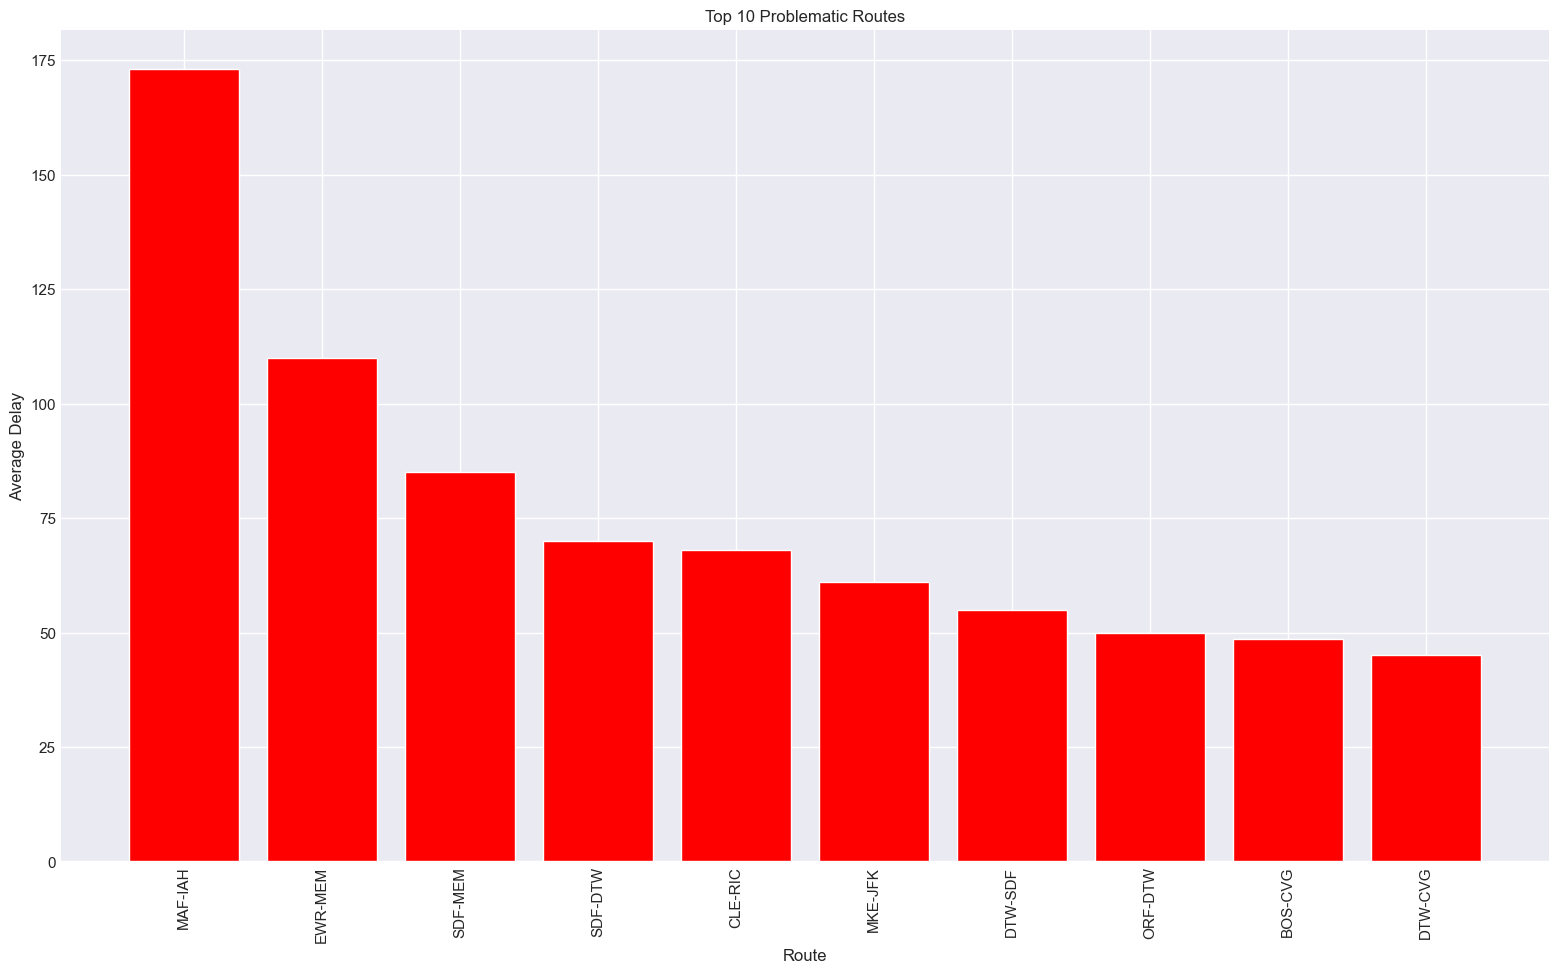

In [ ]:


# Create bar plot for top 10 problematic routes
plt.figure(figsize=(19.2,10.8))
plt.bar(top_10_problematic_routes['ORIGIN'] + "-" + top_10_problematic_routes['DEST'], top_10_problematic_routes['avg_delay'], color='red')
plt.xlabel('Route')
plt.ylabel('Average Delay')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.title('Top 10 Problematic Routes')
plt.show()

In [ ]:
# Lowest level of congestion: You can calculate the number of flights per airport to estimate the level of congestion
flights_by_airport = df.groupBy("ORIGIN").count()
flights_by_airport.sort("count").show()

cancelled_flights_by_airline = df.filter(df["CANCELLED"] == 1).groupBy("OP_CARRIER").count()
cancelled_flights_by_airline.show()



+------+-----+
|ORIGIN|count|
+------+-----+
|   MSN|    1|
|   SAV|    1|
|   ATW|    1|
|   RSW|    1|
|   MAF|    1|
|   JAN|    1|
|   XNA|    1|
|   IAD|    1|
|   MIA|    1|
|   ELP|    1|
|   ICT|    1|
|   HSV|    1|
|   TUS|    1|
|   MDW|    1|
|   FWA|    1|
|   BTR|    1|
|   BRO|    2|
|   PVD|    2|
|   AVL|    2|
|   CHS|    2|
+------+-----+
only showing top 20 rows

+----------+-----+
|OP_CARRIER|count|
+----------+-----+
|        MQ|    1|
|        OH|    2|
+----------+-----+



C:\Users\jadencoin\AppData\Local\Temp\ipykernel_12276\3201916687.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


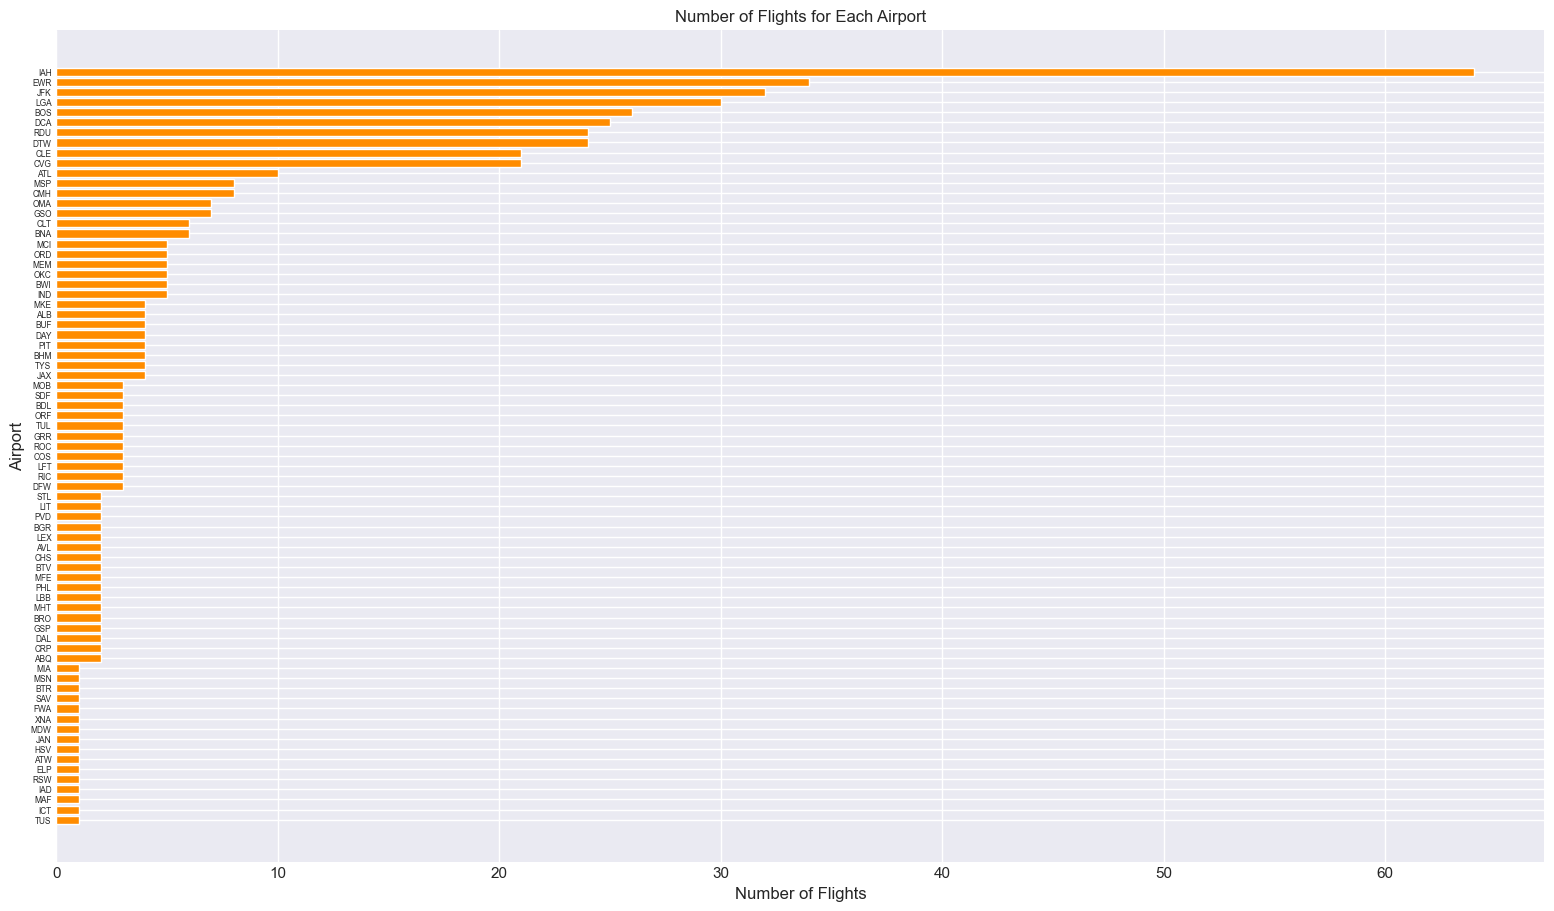

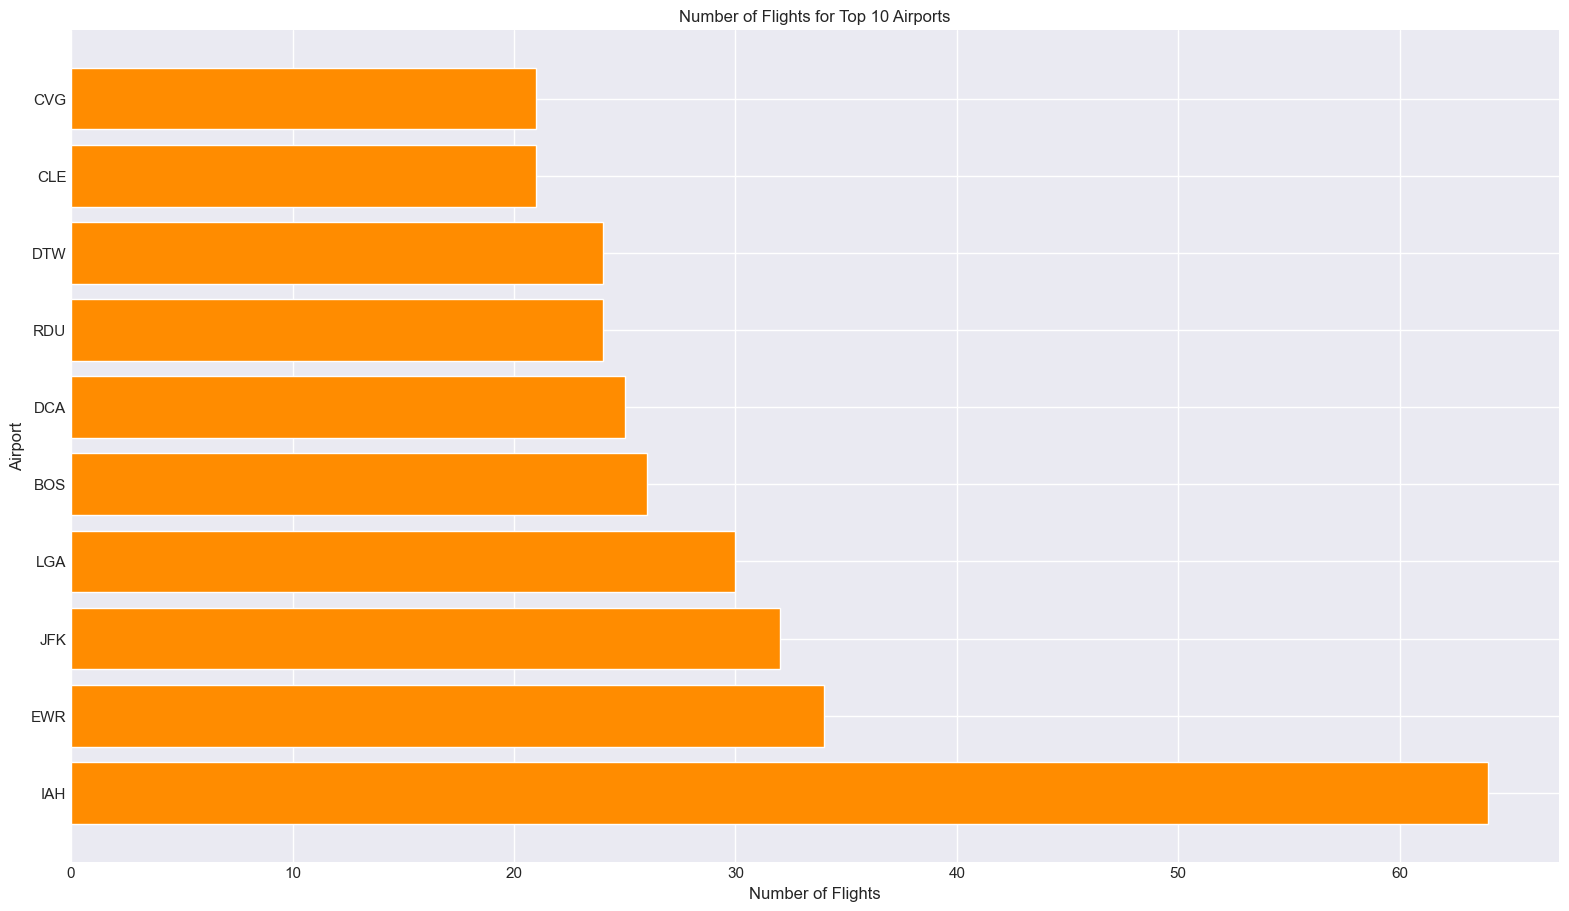

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Use a different theme
plt.style.use('seaborn-darkgrid')

# Convert to Pandas DataFrame for easier plotting
flights_by_airport_df = flights_by_airport.toPandas()

# Sort the DataFrame by count
flights_by_airport_df = flights_by_airport_df.sort_values('count')

# Create bar plot
plt.figure(figsize=(19.2,10.8))
plt.barh(flights_by_airport_df['ORIGIN'], flights_by_airport_df['count'], color='darkorange')
plt.xlabel('Number of Flights')
plt.ylabel('Airport')
plt.yticks(fontsize=6)
plt.title('Number of Flights for Each Airport')
plt.show()

# Sort the DataFrame by count and select top 10 airports
top_10_airports = flights_by_airport_df.sort_values('count', ascending=False).head(10)

# Create bar plot
plt.figure(figsize=(19.2,10.8))
plt.barh(top_10_airports['ORIGIN'], top_10_airports['count'], color='darkorange')
plt.xlabel('Number of Flights')
plt.ylabel('Airport')
plt.title('Number of Flights for Top 10 Airports')
plt.show()


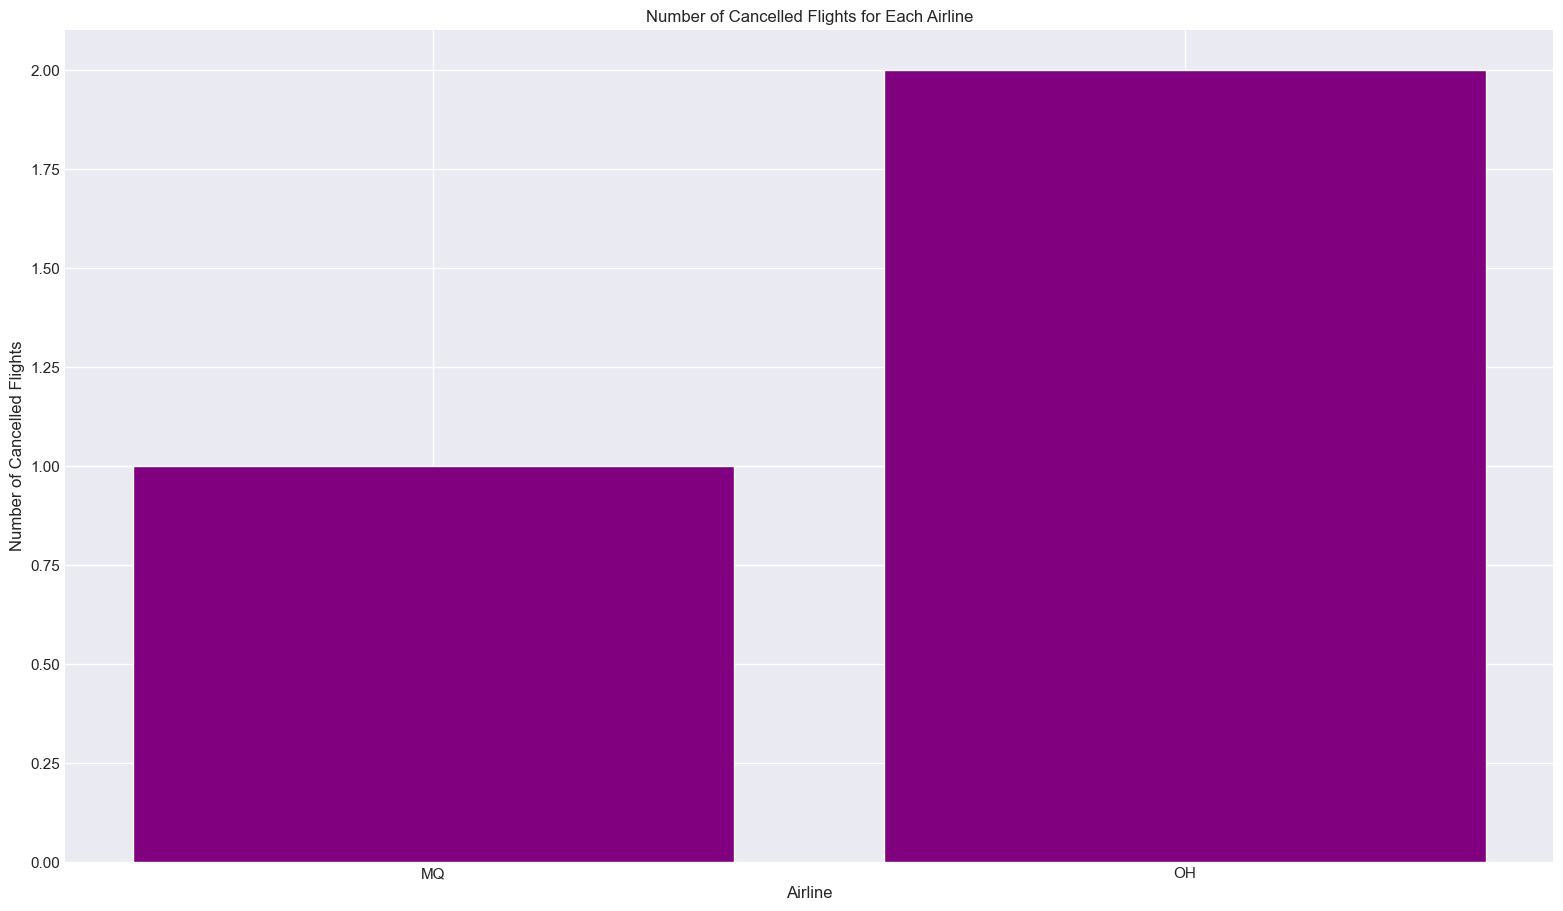

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas DataFrame for easier plotting
cancelled_flights_df = cancelled_flights_by_airline.toPandas()

# Create bar plot
plt.figure(figsize=(19.2,10.8))
plt.bar(cancelled_flights_df['OP_CARRIER'], cancelled_flights_df['count'], color='purple')
plt.xlabel('Airline')
plt.ylabel('Number of Cancelled Flights')
plt.title('Number of Cancelled Flights for Each Airline')
plt.show()


In [ ]:
# Missing values strategy: You can count the number of missing values in each column to decide on a strategy.
from pyspark.sql.functions import isnan, when, count, col

# df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+---------+-------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|flight_id|FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+---------+-------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------

In [ ]:
# Classification - Delay vs. not delayed: You can create a binary column is_delayed where 1
# indicates the flight was delayed and 0 indicates it was not. A flight is considered delayed if the DEP_DELAY is greater than 0.

from pyspark.sql.functions import when

df = df.withColumn("is_delayed", when(df["DEP_DELAY"] > 0, 1).otherwise(0))



In [ ]:
from pyspark.sql.functions import col

# Total number of flights by each airline
total_flights_by_airline = df.groupBy("OP_CARRIER").count().withColumnRenamed('count', 'total_flights')

# Number of delayed flights by each airline
delayed_flights_by_airline = df.filter(df["DEP_DELAY"] > 0).groupBy("OP_CARRIER").count().withColumnRenamed('count', 'delayed_flights')

# Join the two DataFrames and calculate delay probability
delay_probability_by_airline = total_flights_by_airline.join(delayed_flights_by_airline, "OP_CARRIER")
delay_probability_by_airline = delay_probability_by_airline.withColumn("delay_probability", col("delayed_flights") / col("total_flights"))
delay_probability_by_airline.show()

# Number of cancelled flights by each airline
cancelled_flights_by_airline = df.filter(df["CANCELLED"] == 1).groupBy("OP_CARRIER").count().withColumnRenamed('count', 'cancelled_flights')

# Join the two DataFrames and calculate cancellation probability
cancel_probability_by_airline = total_flights_by_airline.join(cancelled_flights_by_airline, "OP_CARRIER")
cancel_probability_by_airline = cancel_probability_by_airline.withColumn("cancel_probability", col("cancelled_flights") / col("total_flights"))
cancel_probability_by_airline.show()



+----------+-------------+---------------+-------------------+
|OP_CARRIER|total_flights|delayed_flights|  delay_probability|
+----------+-------------+---------------+-------------------+
|        MQ|          115|             35|0.30434782608695654|
|        OH|          134|             35|0.26119402985074625|
|        XE|          249|             54|0.21686746987951808|
+----------+-------------+---------------+-------------------+

+----------+-------------+-----------------+--------------------+
|OP_CARRIER|total_flights|cancelled_flights|  cancel_probability|
+----------+-------------+-----------------+--------------------+
|        MQ|          115|                1|0.008695652173913044|
|        OH|          134|                2|0.014925373134328358|
+----------+-------------+-----------------+--------------------+



In [ ]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for easier plotting
total_df = total_flights_by_airline.toPandas()
delayed_df = delay_probability_by_airline.toPandas()
cancelled_df = cancel_probability_by_airline.toPandas()

# Merge the dataframes
merged_df = total_df.merge(delayed_df, on='OP_CARRIER').merge(cancelled_df, on='OP_CARRIER')

# Set the index to be the airline for easier plotting
merged_df.set_index('OP_CARRIER', inplace=True)

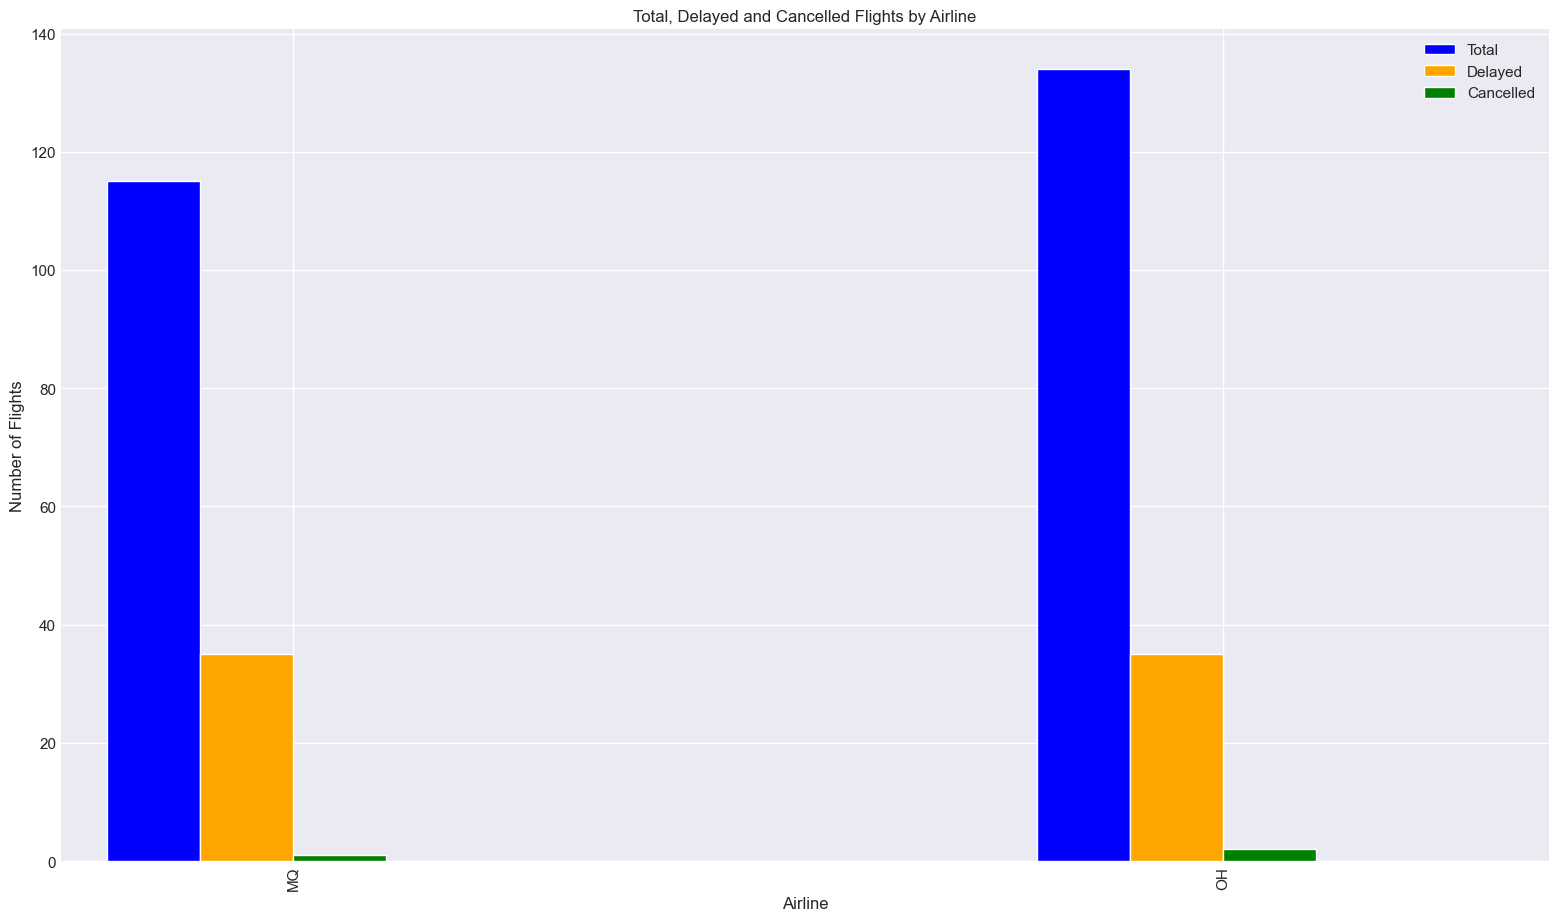

In [ ]:


# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(19.20, 10.80))

# Plot total flights
merged_df['total_flights'].plot(kind='bar', color='blue', ax=ax, width=0.1, position=2)

# Plot delayed flights
(merged_df['total_flights'] * merged_df['delay_probability']).plot(kind='bar', color='orange', ax=ax, width=0.1, position=1)

# Plot cancelled flights
(merged_df['total_flights'] * merged_df['cancel_probability']).plot(kind='bar', color='green', ax=ax, width=0.1, position=0)

# Set labels and title
ax.set_xlabel('Airline')
ax.set_ylabel('Number of Flights')
plt.title('Total, Delayed and Cancelled Flights by Airline')

# Add legend
ax.legend(["Total", "Delayed", "Cancelled"])

# Show the plot
plt.show()


In [ ]:
# !pip install tensorflow

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.functions import dayofweek

df = df.withColumn("total_delay", col("CARRIER_DELAY") + col("WEATHER_DELAY") + col("NAS_DELAY") + col("SECURITY_DELAY") + col("LATE_AIRCRAFT_DELAY"))
from pyspark.sql.functions import date_format

df = df.withColumn("is_weekend", when(date_format('FL_DATE', 'E').isin(["Sat", "Sun"]), 1).otherwise(0))
from pyspark.sql.functions import concat, lit

df = df.withColumn("route", concat(col("ORIGIN"), lit("_"), col("DEST")))

from pyspark.sql.functions import when

df = df.withColumn('departure_time_of_day',
                   when((col('CRS_DEP_TIME') >= 600) & (col('CRS_DEP_TIME') < 1200), 'morning')
                   .when((col('CRS_DEP_TIME') >= 1200) & (col('CRS_DEP_TIME') < 1700), 'afternoon')
                   .when((col('CRS_DEP_TIME') >= 1700) & (col('CRS_DEP_TIME') < 2100), 'evening')
                   .otherwise('night'))

df = df.withColumn('flight_duration', col('CRS_ARR_TIME') - col('CRS_DEP_TIME'))



df = df.withColumn('day_of_week', dayofweek('FL_DATE'))


df = df.fillna(0)
df.show()

+----------------+--------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+----------+-----------+----------+-------+---------------------+---------------+-----------+
|       flight_id| FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|is_delayed|total_delay|is_weekend|  route|departure_time_of_day|flight_duration|day_of_week|
+----------------+--------+----------+-----------------+------+----+------------+--------+---------+--------+----------+

In [ ]:
#create into dask data frame
pandas_df = df.toPandas()


In [ ]:
# !pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator

In [ ]:
#Using H2O to calculate
import h2o
from h2o.estimators import H2ORandomForestEstimator

h2o.init()

hf = h2o.H2OFrame(pandas_df)

predictors = ['total_delay','route','departure_time_of_day','flight_duration','day_of_week']
response = 'is_delayed'

train, valid = hf.split_frame(ratios=[.8], seed=1234)

model = H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10)
model.train(x=predictors, y=response, training_frame=train, validation_frame=valid)

predictions = model.predict(valid)

performance = model.model_performance(valid)
print(performance)





Checking whether there is an H2O instance running at http://localhost:54321... connected.


H2O_cluster_uptime:,31 mins 19 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_jadencoin_t8dv3c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,71.8 Mb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Users\jadencoin\anaconda3\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [day_of_week]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Users\jadencoin\anaconda3\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.1524690379309227
RMSE: 0.39047283891574674
MAE: 0.2572363752371672
RMSLE: 0.27603534247486106
Mean Residual Deviance: 0.1524690379309227


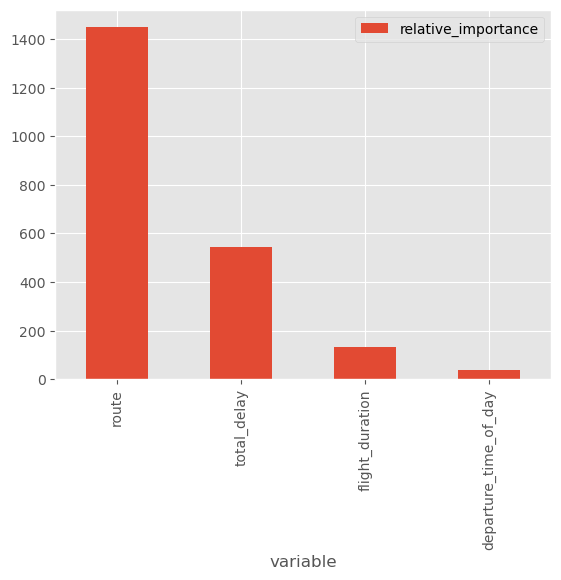

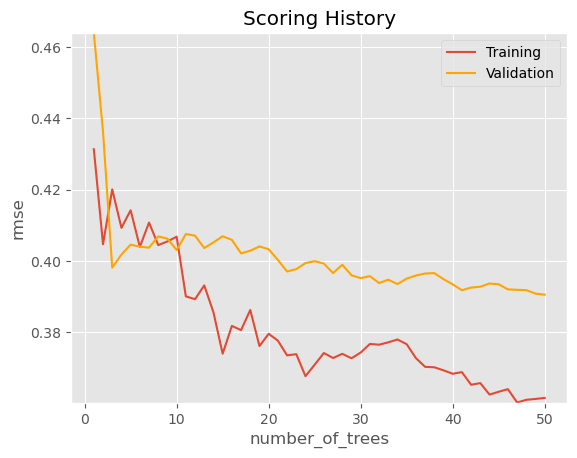

In [ ]:
# Visualizations
# Get variable importance
importance = model.varimp(use_pandas=True)

# Plot variable importance
importance.plot(kind='bar', x='variable', y='relative_importance')

# Plot ROC curve
model.plot(metric='rmse')
